# Detect distracted drivers
*Cyril Pecoraro - June 1st 2018*

The goal is to predict what the driver is doing based on pictures

This project is from a [Kaggle competition : State Farm Distracted Driver Detection
](https://www.kaggle.com/c/state-farm-distracted-driver-detection)

There are 10 classes to predict:
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

### Explanation of my work

I used a pre-trained VGG-16 Convolutional Neural Network as a base layer. I then removed the last layer (=top layer) and added a Dense layer with a softmax to output the classification. The optimization algorithm is Adam with a small learning rate: **/tofill/**  . 


The used the weights trained VGG-16 on the image-net dataset. All the layers beside the last **/tofill/**  were frozen. I fine tuned the model using the training set and a validation set (25% split)


**/tofill/** epochs were used. The learning_rate, number of epochs and numbers of layers to freeze values were determined by several experiments, not shown here. 


The framework was run on a Google Cloud Virtual Machine with a Tesla K80 GPU.

#### To predict:
Use the script `predict.py [Model/model_name]` to obtain prediction and generate a .csv file for Kaggle.

### Content:

1. File loading and Preprocessing
2. Model building and training

#### Parameters to adjust:

In [1]:
# Params 
batch_size = 128
n_epoch = 8
learning_rate = 0.00005
n_layers_freeze = 2

In [2]:
import pandas as pd
import cv2
import os 
import glob
import gc
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import warnings
warnings.filterwarnings("ignore", module="matplotlib")
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from keras.applications import vgg16
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense
from keras import callbacks

from tensorflow.python.client import device_lib
import tensorflow as tf

from livelossplot import PlotLossesKeras


Using TensorFlow backend.


## 1. File Loading and preprocessing

First we can observe the distribution of samples per class. This is important as it is a classification problem. In order to avoid the [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox), we don't want to have classes too imbalanced. Here the classes are pretty well balanced. All good !

To load the files quickly, I use a multi-processor approach which allows to multiply by at least 5 the loading speed.

The data are then preprocess according th VGG-16 requirements: input of size 224\*224 and mean substraction


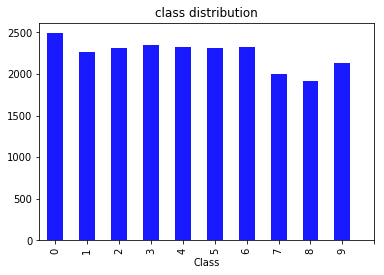

In [3]:
img_list = pd.read_csv('Data/driver_imgs_list.csv')

img_list['class_type'] = img_list['classname'].str.extract('(\d)',expand=False).astype(np.int)
plt.figure()
img_list.groupby(['class_type'])['subject'].count().plot(kind='bar',alpha=0.9, layout=(1,1), color='b')
plt.title('class distribution')
plt.xticks(range(0,11))
plt.xlabel('Class')
plt.show()


In [4]:
def load_image(img_file, img_reshape_size):
    """Load an image
    Args:
    - img_file: image file
    - img_reshape_size: shape(w,h) to resize the image
    Return:
    - img: openCV image
    """   
    img = cv2.imread(img_file)
    img = cv2.resize(img, img_reshape_size)
    # Preprocess input according to VGG16
    vgg16.preprocess_input(img)
    
    return img

def load_train_dataset(dataset_dir, img_reshape_size, nprocs=10):
    """Load the images located in the main folder dataset_dir Each class is in a separate subfolder
    Args:
    - dataset_dir: path to the directory containing subdirectories of images
    - img_reshape_size: shape(w,h) to resize the image
    - nprocs:Number of processors to use
    Return:
    - X: numpy array with each image data as a row
    - y: numpy array with each class as an integer for each image
    """
    X = []
    y = []
    # Train dataset
    for i in range(10):
        path = os.path.join(dataset_dir, 'c'+str(i),'*.jpg')
        files = glob.glob(path)

        X.extend(Parallel(n_jobs=nprocs)(delayed(load_image)(im_file, img_reshape_size) for im_file in files))
        y.extend([i]*len(files))
        print('folder train/c'+str(i), 'loaded')

    X = np.array(X)
    y = np.array(y)
    return X, y

def convert_to_one_hot(Y, C=10):
    """Convert vector to one-hot representation
    Args:
    - Y: numpy vector
    - C: number of different categories
    Return:
    - Y: numpy array with one-hot encoded
    """    
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

    
def plot_training_curves(model_history):
    """Prints accuracy and Loss training curves in 2 subplots
    Args:
    - model_history: Keras model.fit() object
    Return:
    /
    """
    acc = model_history.history['acc']
    val_acc = model_history.history['val_acc']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(len(acc))
    
    fig = plt.figure(figsize=(12, 6))
    # Accuracy
    plt.subplot(1,2,1) 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2) 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


In [5]:
# Working directories#  
dataset_dir = 'Data'
dataset_dir_train = os.path.join(dataset_dir, 'train')

# Image sizes - Requirements of the CNN model
img_reshape_size = (224,224)

# Load train dataset
print('Load dataset train')
X_train_, y_train_ = load_train_dataset(dataset_dir_train, img_reshape_size)

Load dataset train
folder train/c0 loaded
folder train/c1 loaded
folder train/c2 loaded
folder train/c3 loaded
folder train/c4 loaded
folder train/c5 loaded
folder train/c6 loaded
folder train/c7 loaded
folder train/c8 loaded
folder train/c9 loaded


Creation of a validation set. The chosen split is 25%, randomly. 


In [6]:
# Creation of a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, 
                                                  test_size=0.25, 
                                                  random_state=35)

# One-hot encoding of the target vector
y_train = convert_to_one_hot(y_train)
y_val = convert_to_one_hot(y_val)


# Shapes 
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

X_train shape: (16818, 224, 224, 3)
y_train shape: (16818, 10)
X_val shape: (5606, 224, 224, 3)
y_val shape: (5606, 10)


## 2. Model building and training

In [7]:
def create_VGG16_model(n_classes=10, n_layers_freeze=1, input_shape=(224, 224, 3), learning_rate=0.0001):
    """Load the images located in the main folder dataset_dir Each class is in a separate subfolder
    Args:
    - n_classes: number of classes to predict for the classifier
    - n_layers_freeze: number of last layers to freeze so that they are not trained again
    Return:
    - model: Keras model
    """
    #Load the VGG model
    vgg16_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers except the last n_layers_freeze layers
    for layer in vgg16_base.layers[:-n_layers_freeze]:
        layer.trainable = False

    model = Sequential(name='VGG16-classifier')
    model.add(vgg16_base)
    model.add(Flatten(input_shape=model.output_shape[1:]))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',
          optimizer=optimizers.Adam(lr=learning_rate),
          metrics=['accuracy'])

    model.summary()
    return model

In [8]:
# Create and compile model
model = create_VGG16_model(n_layers_freeze=n_layers_freeze, learning_rate=learning_rate)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                250890    
Total params: 14,965,578
Trainable params: 2,610,698
Non-trainable params: 12,354,880
_________________________________________________________________


In [9]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5224262582945595249
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11272526234
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2559636879286488457
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


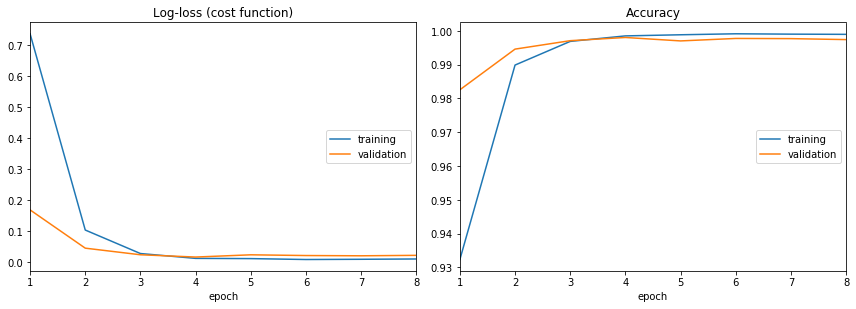

In [10]:
model_history = model.fit(x=X_train, y=y_train,
          batch_size=batch_size,
          epochs=n_epoch,
          shuffle=True,
          verbose=2,
          validation_data=(X_val, y_val),
          callbacks=[PlotLossesKeras()]
          )

In [11]:
y_pred_val = model.predict(X_val, batch_size=batch_size, verbose=1)
score_val = log_loss(y_val, y_pred_val)
print('Validation Log loss:', np.round(score_val,3))

5606/5606 [==============================] - 54s 10ms/step
Validation Log loss: 0.173


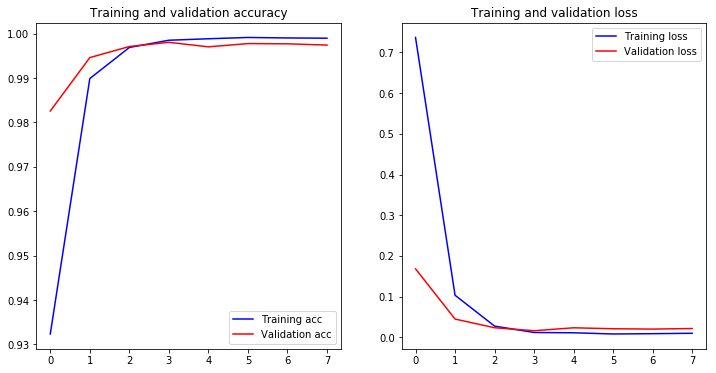

In [12]:
plot_training_curves(model_history)

Now that the model is trained, we can save it and exit this notebook.

Use the script `predict.py [Model/model_name]` to obtain prediction and generate a .csv file for Kaggle

In [13]:
# Save model and Exit
if not os.path.isdir('Model'):
    os.mkdir('Model')
filename = 'VGG16_lr'+str(learning_rate)+'_freeze'+str(n_layers_freeze)+'_epochs'+str(n_epoch)+'.h5'
sub_file = os.path.join('Model', filename)
model.save(sub_file)
print('File', filename, 'saved')


File VGG16_lr0.0001_freeze2_epochs8.h5 saved


In [ ]:
# Exit and kill kernel
os._exit(00)